In [1]:
import astropy.io.fits as fits
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from astropy.cosmology import Planck15 as cosmo


from galaxy_cluster_matching import match_galaxies_and_clusters
from completeness import create_completeness_dataframe
from mass_function import get_weighted_mass_histogram, get_region_volume 
from constants import MASS_BINS, Z_MAX
from richard_curve import get_mass_luminosity_cutoff, get_distance_from_mass, filter_for_richards_curve
from soumya_mcmc import fit_schechter_function2data, do_corner_plot, schechter_function

In [2]:
# Loading the data

# big survey
sciencegkv_galaxies_raw = fits.open('../Data/GAMA/gkvScienceCatv02/gkvScienceCatv02.fits')[1].data

# small survey
galaxies_raw = fits.open('../Data/GAMA/merged/StellarMass-gkvScience/mergedStellarMass-gkvScience')[1].data

# cluster survey
clusters_raw = fits.open('../Data/eRASS/merged_primary&optical_clusters/merged_optical_primary_clusters.fits')[1].data

In [3]:
# Masks

# big survey masks
sciencegkv_galaxy_mask = (
    (sciencegkv_galaxies_raw['uberclass'] == 1) &           # classified as galaxy
    (sciencegkv_galaxies_raw['duplicate'] == 0) &           # unique object
    (sciencegkv_galaxies_raw['mask'] == False) &
    (sciencegkv_galaxies_raw['starmask'] == False) &
    (sciencegkv_galaxies_raw['Z'] < Z_MAX) &
    (sciencegkv_galaxies_raw['flux_rt'] >= 5.011928e-05)    # maximum magnitude of 19.65 in r-band
)

# small survey masks
galaxy_mask = (
        (galaxies_raw['uberclass'] == 1) &           # classified as galaxy
        (galaxies_raw['duplicate'] == 0) &
        (galaxies_raw['mask'] == False) &
        (galaxies_raw['starmask'] == False) &
        (galaxies_raw['mstar'] > 0) &
        (galaxies_raw['NQ'] > 2) &                 # reliable redshift
        (galaxies_raw['Z'] != 0) &
        (galaxies_raw['Z'] != -9.999) &
        (galaxies_raw['Z'] < Z_MAX) &
        (galaxies_raw['flux_rt'] >= 5.011928e-05)
)

# cluster masks
cluster_mask = (
        ~np.isnan(clusters_raw['VDISP_BOOT']) &     # Merged
        (clusters_raw['BEST_Z'] <= Z_MAX) &         # Merged
    (
        ((clusters_raw['RA'] > 129.0) & (clusters_raw['RA'] < 141.0) & (clusters_raw['DEC'] > -2.0) & (clusters_raw['DEC'] < 3.0)) |
        ((clusters_raw['RA'] > 174.0) & (clusters_raw['RA'] < 186.0) & (clusters_raw['DEC'] > -3.0) & (clusters_raw['DEC'] < 2.0)) |
        ((clusters_raw['RA'] > 211.5) & (clusters_raw['RA'] < 223.5) & (clusters_raw['DEC'] > -2.0) & (clusters_raw['DEC'] < 3.0)) |
        ((clusters_raw['RA'] > 339.0) & (clusters_raw['RA'] < 351.0) & (clusters_raw['DEC'] > -35.0) & (clusters_raw['DEC'] < -30.0))
    ) &
        (clusters_raw['R500'] != -1)             # Merged??????????????????????????????????????????????????
    
)

big_galaxy_catalog = sciencegkv_galaxies_raw[sciencegkv_galaxy_mask]
galaxy_catalog = galaxies_raw[galaxy_mask]
cluster_catalog = clusters_raw[cluster_mask]

In [4]:
# Dataframes
cluster_df = pd.DataFrame({
    # 'c_ID': cluster_catalog['ID-SRC'].byteswap().newbyteorder(),        #eFEDS
    'c_ID': cluster_catalog['DETUID'].byteswap().newbyteorder(),
    'c_NAME': cluster_catalog['NAME'].byteswap().newbyteorder(),
    'RA': cluster_catalog['RA'].byteswap().newbyteorder(),
    'DEC': cluster_catalog['DEC'].byteswap().newbyteorder(),
    'z': cluster_catalog['BEST_Z'].byteswap().newbyteorder(),
    'cluster_radius_kpc': cluster_catalog['R500'].byteswap().newbyteorder(),
    # 'cluster_radius_Mpc': cluster_catalog['R_LAMBDA'].byteswap().newbyteorder(),              # eFEDS
    # 'cluster_Velocity_Dispersion': cluster_catalog['VDISP'].byteswap().newbyteorder(),        # eFEDS
    'cluster_Velocity_Dispersion': cluster_catalog['VDISP_BOOT'].byteswap().newbyteorder(),

})

# Creating the galaxy DataFrame and merging with mass data 
galaxy_df = pd.DataFrame({
        'uberID': galaxy_catalog['uberID'].byteswap().newbyteorder(),
        'RA': galaxy_catalog['RAcen'].byteswap().newbyteorder(),
        'DEC': galaxy_catalog['Deccen'].byteswap().newbyteorder(),
        'z': galaxy_catalog['Z'].byteswap().newbyteorder(),
        'mstar': galaxy_catalog['mstar'].byteswap().newbyteorder(),
        'flux_rt': galaxy_catalog['flux_rt'].byteswap().newbyteorder(),
})

completeness_region_df = create_completeness_dataframe(big_survey=big_galaxy_catalog,
                                                           small_survey=galaxy_catalog,
                                                           flux_type='flux_rt',
                                                           region="G09")
completeness_region_df['region'] = "G09"

# Convert kpc to Mpc
cluster_df['cluster_radius_Mpc'] = cluster_df['cluster_radius_kpc'] / 1000

/Users/benediktillich/Farnoosh_thesis/Thesis_code/completeness.py:52: RuntimeWarning: invalid value encountered in divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)


In [5]:
matched_galaxy_dataframe = pd.read_csv('matched_galaxy_df.csv')

In [6]:
# merge the df with the completeness with the df with the galaxy environment
merged_galaxy_df = pd.merge(completeness_region_df, matched_galaxy_dataframe, how="inner", on="uberID")
merged_galaxy_df['comoving_distance'] = cosmo.comoving_distance(merged_galaxy_df['z']).value

In [7]:
# find the galaxies within the richards curve
mass_for_richards_curve = np.logspace(5,12.25, 1000)
mass_luminosity_cutoff = get_mass_luminosity_cutoff(merged_galaxy_df, cut_off_percentage=80)
richards_curve = get_distance_from_mass(mass_for_richards_curve, log_cutoff_mass_to_light_ratio=mass_luminosity_cutoff)
merged_galaxy_df['within_richards_curve'] = merged_galaxy_df.apply(lambda row: filter_for_richards_curve(richards_curve, mass_for_richards_curve, row['mstar'], row['comoving_distance']), axis=1)

In [8]:
# find the mass function
#mass_histogram, mass_histogram_error = get_weighted_mass_histogram(merged_galaxy_df[merged_galaxy_df['within_richards_curve']], region_name='G09')
#stellar_mass_function = mass_histogram / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)

In [9]:
#np.savetxt("mass_histogram.txt", mass_histogram)
#np.savetxt("mass_histogram_error.txt", mass_histogram_error)

In [10]:
# load the mass function
mass_histogram, mass_histogram_error = np.loadtxt("mass_histogram.txt"), np.loadtxt("mass_histogram_error.txt")

In [33]:
log_mass_bin_means = np.log10([MASS_BINS[i+1] - MASS_BINS[i] for i in range(len(MASS_BINS)-1)])
initial = np.array([1000, 11, -2]) # phi_s, m_s, alpha
priors = ((1, 1), (5, 25), (-5, 10))
corrected_mass_function_errors = np.array([error if error != 0 else 100000.0 for error in mass_histogram_error])

In [36]:
fit_results = fit_schechter_function2data(xbin=log_mass_bin_means, ydata=mass_histogram, ydata_err=corrected_mass_function_errors, fit_with='schechter_function', initial=initial, prior_ranges=priors, n_steps=5000)
phi_s_fit = np.average(fit_results[:,0])
m_s_fit = np.average(fit_results[:,1])
alpha_fit = np.average(fit_results[:,2])

You must install the tqdm library to use progress indicators with emcee


phi_s_ml=3191.42, m_s_ml=8.37, alpha_ml=5.37
${Phi_s} = 947.582_{-279.436}^{+393.906}$
${m_s} = 6.716_{-0.401}^{+0.429}$
${lpha} = 5.655_{-0.085}^{+0.089}$


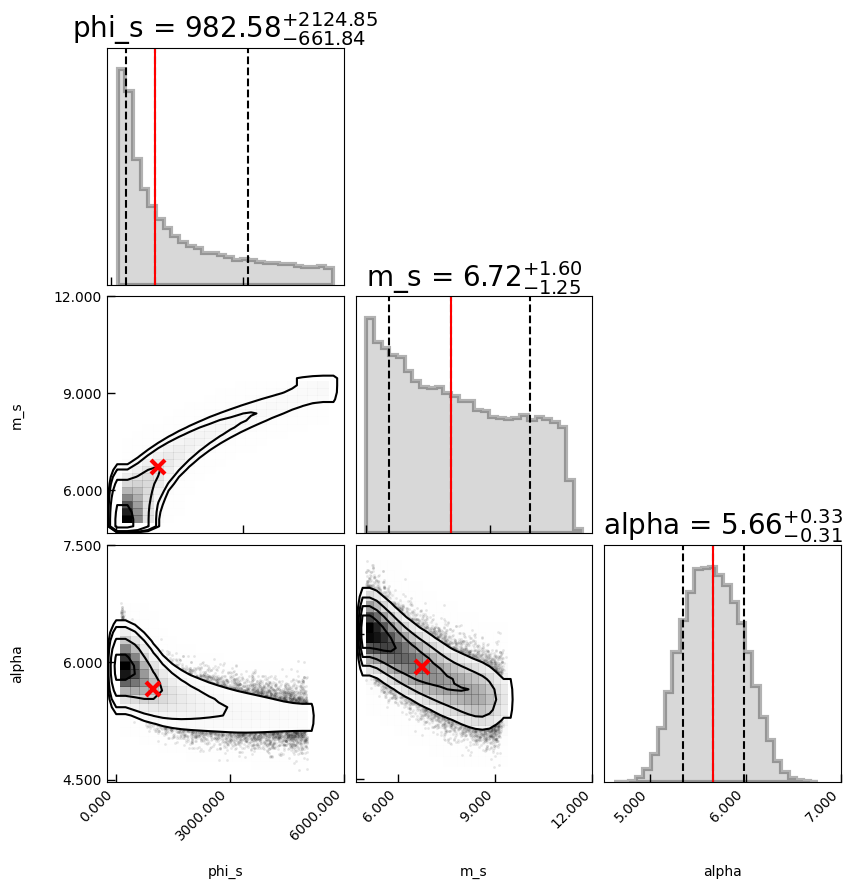

In [37]:
do_corner_plot(fit_results)

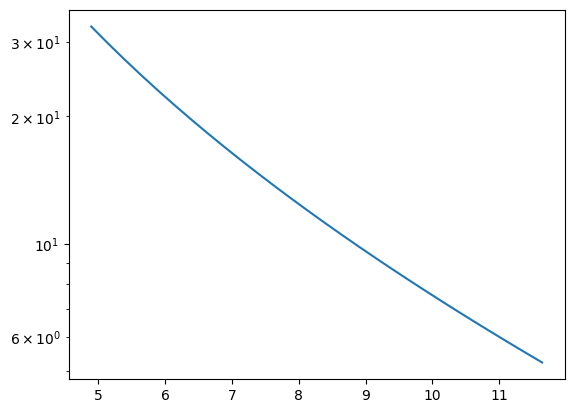

In [47]:
test_theta = 20, 10.18, -1.3
schechter_function_test = 200 * (log_mass_bin_means / 10.18 )**(-1.35) * np.exp(- ( log_mass_bin_means/ 10.18 ) ) / 10.18

plt.yscale("log"), plt.xscale("linear")
plt.plot(log_mass_bin_means, schechter_function_test)